<a href="https://colab.research.google.com/github/mersalas/ecosa/blob/main/ecoli_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages
!pip install pyforest
!pip install deepchem
!pip install shap

In [2]:
# Import necessary libraries
from pyforest import*
lazy_imports() # load most libraries
import deepchem as dc
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import joblib
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import shap
from shap import Explanation
from shap.plots import waterfall
shap.initjs()

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
# Featurize smiles
dataset_file = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Ecoli_clean.csv'
tasks = ['Ecoli']

featurizer = dc.feat.CircularFingerprint(radius=6, size=2048, chiral = True, bonds = True)
loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

In [4]:
# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.20, random_state=42, stratify=dataset.y)

print("Size of training set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

<IPython.core.display.Javascript object>

Size of training set: 1761   size of test set: 441



In [5]:
# Train SVC
svc = SVC(C=5.0742, kernel='rbf', gamma=4.9803e-3, class_weight='balanced', probability=True,
          random_state=42)
svc.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

SVC(C=5.0742, class_weight='balanced', gamma=0.0049803, probability=True,
    random_state=42)

In [6]:
# Train XGB
xgb = XGBClassifier(tree_method='hist', device='cuda', objective='binary:logistic', scale_pos_weight=1,
                    learning_rate=0.11288, n_estimators=678, gamma=1.2743e-5, max_depth=20,
                    subsample=0.73684, colsample_bytree=0.73684, alpha=7.8476e-2, random_state=42)
xgb.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

XGBClassifier(alpha=0.078476, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.73684, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.2743e-05,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11288, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=678, n_jobs=None,
              num_parallel_tree=None, ...)

In [7]:
# Train LGBM
lgbm = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True,
                      n_estimators=910, learning_rate=0.23357, num_leaves=193,
                      max_depth=16, min_data_in_leaf=93, bagging_fraction=0.9,
                      bagging_freq=1, feature_fraction=0.7, verbose=-1, random_state=42)
lgbm.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='cpu',
               feature_fraction=0.7, is_unbalance=True, learning_rate=0.23357,
               max_depth=16, min_data_in_leaf=93, n_estimators=910,
               num_leaves=193, objective='binary', random_state=42, verbose=-1)

In [8]:
# Train voting model
vote = VotingClassifier(estimators=[('svc', svc), ('xgb', xgb), ('lgbm', lgbm)], voting='soft')

vote.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

VotingClassifier(estimators=[('svc',
                              SVC(C=5.0742, class_weight='balanced',
                                  gamma=0.0049803, probability=True,
                                  random_state=42)),
                             ('xgb',
                              XGBClassifier(alpha=0.078476, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.73684,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metri...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=678, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='cpu',
                                             feature_fraction=0.7,
                                             is_unbalance=True,
                                             learning_rate=0.23357,
                                             max_depth=16, min_data_in_leaf=93,
                                             n_estimators=910, num_leaves=193,
                                             objective='binary',
                                             random_state=42, verbose=-1))],
                 voting='soft')

In [10]:
# Evaluate the voting model on training set
print("Performance of vote model on training set")
y_train_pred = cross_val_predict(vote, X_train, np.ravel(y_train), cv=10)
print("accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.2f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.2f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.2f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.2f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of vote model on training set


<IPython.core.display.Javascript object>

accuracy: 0.82
precision: 0.83
sensitivity: 0.88
F1: 0.85
MCC: 0.63
AUROC: 0.81


In [11]:
# Save the model
joblib.dump(vote, "ecoli.pkl")

['ecoli.pkl']

In [12]:
# Load the model
ecoli = joblib.load('ecoli.pkl')

In [13]:
# Evaluate the voting model on test set
y_pred = ecoli.predict(X_test)
y_proba = ecoli.predict_proba(X_test)[:, 1]
print("Performance of vote model on test set")
print("accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("sensitivity: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1: {:.2f}".format(f1_score(y_test, y_pred)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_pred)))
print("AUROC: {:.2f}".format(roc_auc_score(y_test, y_proba)))

Performance of vote model on test set
accuracy: 0.82
precision: 0.85
sensitivity: 0.85
F1: 0.85
MCC: 0.64
AUROC: 0.89


In [14]:
# Featurize own peptides
dataset_file = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Ecoli_test.csv'
tasks = ['Ecoli']

featurizer = dc.feat.CircularFingerprint(radius=6, size=2048, chiral = True, bonds = True)
loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

In [15]:
# Convert dataset.X to dataframe
X = pd.DataFrame(dataset.X)
col = ['ECFP' + str(x) for x in range(0,2048)]
X.columns = col
X.head()

<IPython.core.display.Javascript object>

,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,...,ECFP2038,ECFP2039,ECFP2040,ECFP2041,ECFP2042,ECFP2043,ECFP2044,ECFP2045,ECFP2046,ECFP2047
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Predict activity of own peptides
pred = ecoli.predict(X)
pred

X has feature names, but SVC was fitted without feature names


array([1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.])

**Feature importance**

In [17]:
# SHAP values
explainer = shap.KernelExplainer(ecoli.predict, X)
shap_values = explainer.shap_values(X)

  0%|          | 0/11 [00:00<?, ?it/s]

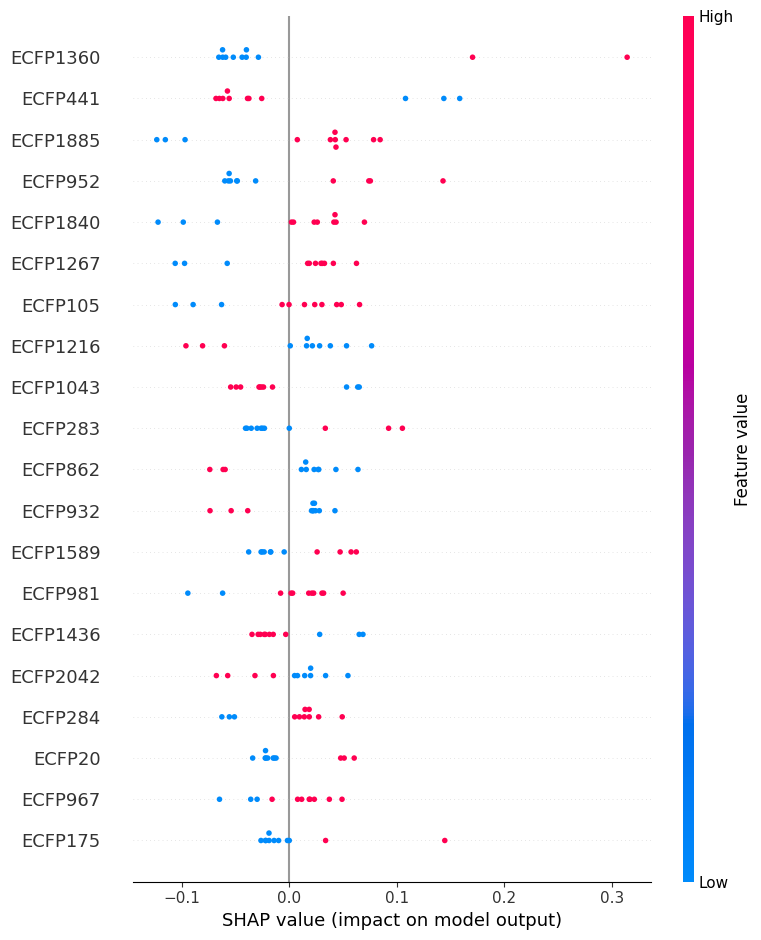

In [18]:
shap.summary_plot(shap_values, X)

Example: C14-ano-NH2

In [19]:
# Plot the SHAP values for the 1st observation as force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

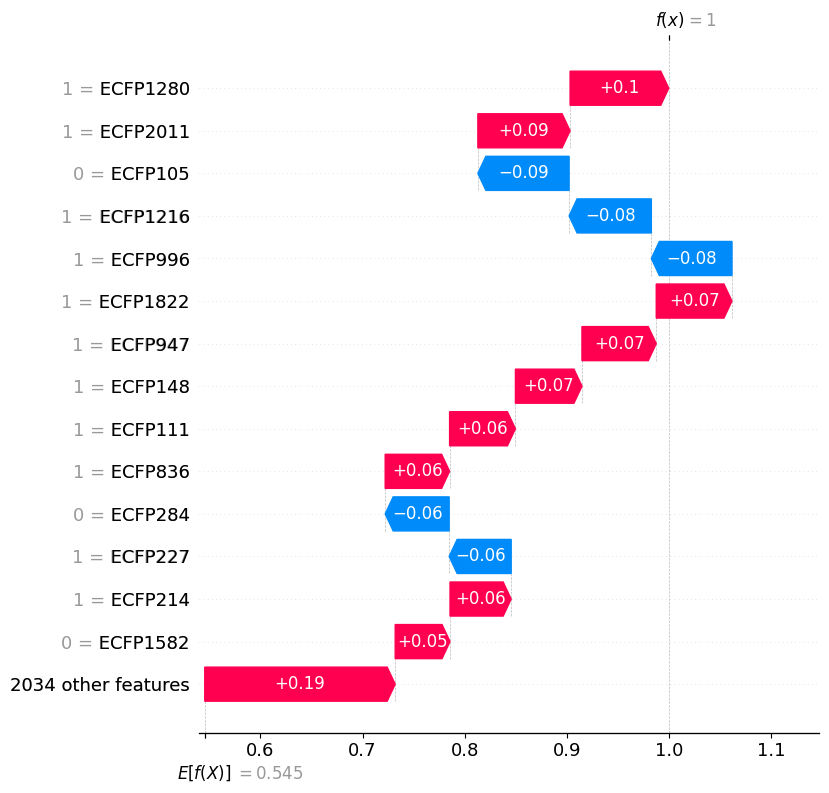

In [22]:
# Plot the SHAP values for the 1st observation as waterfall
exp = Explanation(shap_values, explainer.expected_value, data=X.loc[[0]].values, feature_names=X.columns)
waterfall(exp[0], max_display=15)

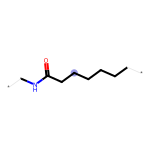

In [23]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
mol = Chem.MolFromSmiles('CCCCCCCCCCCCCC(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(N)=O)[C@@H](C)O')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=6, bitInfo=bi, nBits=2048)
bi[1280]
mfp1 = Draw.DrawMorganBit(mol, 1280, bi, useSVG=True)
mfp1

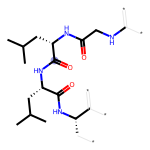

In [25]:
bi[111]
mfp2 = Draw.DrawMorganBit(mol, 111, bi, useSVG=True)
mfp2

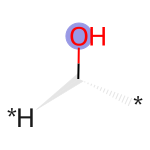

In [26]:
bi[227]
mfp3 = Draw.DrawMorganBit(mol, 227, bi, useSVG=True)
mfp3

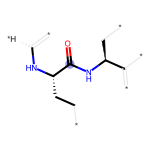

In [29]:
bi[105]
mfp4 = Draw.DrawMorganBit(mol, 105, bi, useSVG=True)
mfp4